In [2]:
import os
os.environ["JAVA_HOME"] = "/dbr1/hctl/spark_essentials/jdk1.8.0_251/"
os.environ["SPARK_HOME"] = "/usr/local/spark-2.4.0-bin-hadoop2.7/"

In [3]:
import findspark
findspark.init()


from pyspark_iforest.ml.iforest import *
from decimal import Decimal
from pyspark.ml.linalg import Vectors
import tempfile
import pandas as pd
from pyspark.sql.functions import to_timestamp,to_date
from datetime import datetime
import time
from pyspark.sql import SQLContext,SparkSession

In [4]:
spark = SparkSession.builder.master("local[*]") \
        .appName("IForestExample") \
        .config("spark.jars", "/dbr1/hctl/spark_essentials/mysql-connector-java-5.1.49.jar,/dbr1/hctl/spark_essentials/spark-iforest-2.4.0.jar") \
        .getOrCreate()

# spark = SparkSession.builder.master("local[*]").config("spark.jars", "/dbr1/hctl/spark_essentials/mysql-connector-java-5.1.49.jar,/dbr1/hctl/spark_essentials/spark-iforest-2.4.0.jar").getOrCreate()

sqlContext = SQLContext(spark.sparkContext)

print("Spark Version - ", spark.version)

hostname = "dbclass.cs.nmsu.edu" 
dbname = "nmsu_power"
jdbcPort = 3306
username = "sakumar"
password = "dbnmsu123"
jdbc_url = "jdbc:mysql://{0}:{1}/{2}?user={3}&password={4}".format(hostname,jdbcPort, dbname,username,password)

query = """
( SELECT * FROM (SELECT * FROM power ORDER BY Date DESC, TIME DESC LIMIT 100 ) sub ORDER BY Date ASC, TIME ASC )
whyalias
"""

df_origin = sqlContext.read.format('jdbc').options(driver='com.mysql.jdbc.Driver',url=jdbc_url, dbtable=query ).load()
#df_origin.show()
print("db connected successfully")

Spark Version -  2.4.0
db connected successfully


In [5]:
###### Data Conversion ########

date=df_origin.select(to_date(df_origin['Date'], 'dd/MM/yyyy').alias('date')).collect()
time=df_origin.select(to_timestamp(df_origin['Time'], 'yyyy-MM-dd HH:mm:ss').alias('time')).collect()

date_list=[]
time_list=[]
date_time_list=[]

for da in date:
  row_list=[]
  for d in da:
    row_list.append(d)
  date_list.append(row_list)

for ti in time:
  row_list=[]
  for t in ti:
    row_list.append(t.time())
  time_list.append(row_list)

for i in range(len(time_list)):
  date_time_list.append(datetime.combine(date_list[i][0],time_list[i][0]))

# last=100
# date_time_list = date_time_list[-last:]

columns_to_drop=["Date","Time"]
df1=df_origin.drop(*columns_to_drop)

a=[column for column in df1.columns]
g=df1.select(a).collect()

# record_count=df1.count()
# print(record_count)

size=0
a=[]
for row in g:
    row_data = []
    for data in row:
        if type(data) == Decimal:
            row_data.append(float(data))
        elif type(data) == float:
            row_data.append(float(data))
    a.append(row_data)

# a=a[-last:]
a=[[i / sum(j) for i in j] for j in a]
data = [(Vectors.dense(i),) for i in a]



print("converted data successfully")

converted data successfully


In [6]:
##########################

# Spark-iForest  

##########################

# NOTE: features need to be dense vectors for the model input

df = spark.createDataFrame(data, ["features"])

# Init an IForest Object
iforest = IForest(contamination=0.1,maxDepth=4)
print("init iforest")
# Fit on a given data frame
model = iforest.fit(df)
print("fit iforest")
# Check if the model has summary or not, the newly trained model has the summary info
model.hasSummary

# Show model summary
summary = model.summary

# Show the number of anomalies
summary.numAnomalies

# Predict for a new data frame based on the fitted model
transformed = model.transform(df)

# Collect spark data frame into local df
rows = transformed.collect()

temp_path = tempfile.mkdtemp()
iforest_path = temp_path + "/iforest"

# Save the iforest estimator into the path
iforest.save(iforest_path)

# Load iforest estimator from a path
loaded_iforest = IForest.load(iforest_path)

model_path = temp_path + "/iforest_model"

# Save the fitted model into the model path
model.save(model_path)

# Load a fitted model from a model path
loaded_model = IForestModel.load(model_path)

# The loaded model has no summary info
loaded_model.hasSummary

# Use the loaded model to predict a new data frame
new_df=loaded_model.transform(df)
new_df.show()

init iforest
fit iforest
+--------------------+-------------------+----------+
|            features|       anomalyScore|prediction|
+--------------------+-------------------+----------+
|[0.00238521654184...| 0.5336078179306575|       0.0|
|[0.00239860799427...| 0.5335754238893914|       0.0|
|[0.00241483047402...| 0.5308983171822489|       0.0|
|[0.00243065717165...| 0.5372101499798977|       0.0|
|[0.00242126802703...| 0.5369268713556855|       0.0|
|[0.00242325675950...| 0.5285451641134443|       0.0|
|[0.00242488139167...| 0.5439464218302263|       0.0|
|[0.00204585308826...| 0.4633944592973149|       0.0|
|[0.00168024730630...|0.45262107140983027|       0.0|
|[0.00167976776802...| 0.4530608692473021|       0.0|
|[0.00168502283328...| 0.4571316519255769|       0.0|
|[0.00168744878836...| 0.4882276929205076|       0.0|
|[0.00168221564866...|0.47916668665497436|       0.0|
|[0.00168536581394...|0.45463939679421084|       0.0|
|[0.00168502283328...| 0.4571316519255769|       0.0|
|[0

In [7]:
columns_to_drop=["Date","Time"]
df1=df_origin.drop(*columns_to_drop)

predictions=new_df.select('prediction').collect()
anomalyScores = new_df.select('anomalyScore').collect()

anomalyScores_list=[]
for an in anomalyScores:
  row_list=[]
  for a in an:
    row_list.append(a)
  anomalyScores_list.append(row_list)
anomalyScores_list = [item for sublist in anomalyScores_list for item in sublist]


plist=[]
for an in predictions:
  row_list=[]
  for a in an:
    row_list.append(a)
  plist.append(row_list)
plist = [item for sublist in plist for item in sublist]

# print(plist)

# print(date_time_list)
# print(anomalyScores_list)

anomaly_date=[]
for i,j in zip(plist,date_time_list):
  if(i==1.0):
    anomaly_date.append(j)

# print(anomaly_date)

pred_1=new_df.filter(new_df['prediction']==1.0).select(new_df['anomalyScore']).collect()

pred_list=[]
for an in pred_1:
  row_list=[]
  for a in an:
    row_list.append(a)
  pred_list.append(row_list)
pred_list = [item for sublist in pred_list for item in sublist]

# print(pred_list)
# print(anomalyScores_list)

print("Percentage of anomalies in data: {:.2f}".format( (len(pred_list) / len(plist) )*100))

Percentage of anomalies in data: 10.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f667a3668>]],
      dtype=object)

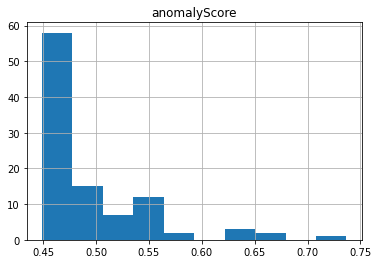

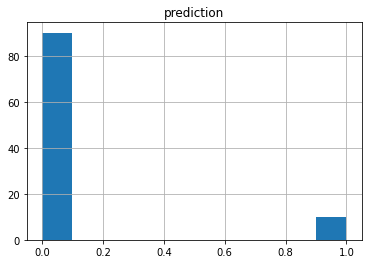

In [8]:
#### Histogram ########


pandas_df=new_df.toPandas()

pandas_df.hist(column='anomalyScore')
pandas_df.hist(column='prediction')

In [10]:
### Plots ########

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import matplotlib.pyplot as plt
# from matplotlib import pyplot
import plotly.graph_objects as go

plot_data=go.Scatter(name='Data',showlegend=True,x=date_time_list, y=anomalyScores_list)
plot_data2=go.Scatter(name='Data2',showlegend=True,x=date_time_list, y=anomalyScores_list)

anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=anomaly_date,
                               y=pred_list,
                               mode='markers',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
fig=go.Figure(data=[plot_data,plot_data2,anomalies_map])
fig.show()